<a href="https://colab.research.google.com/github/darkfapper/Pandoras_Box/blob/main/Bayesian_Neural_Network_Pyro_Classification_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyro-ppl[funsor] lightning

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from pyro.infer import SVI, Trace_ELBO , JitTrace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal , AutoMultivariateNormal , AutoLaplaceApproximation , AutoNormal , AutoNormalizingFlow
from tqdm.auto import trange
from torch.utils.data import DataLoader
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import Predictive
from scipy import stats as st
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,f1_score
from sklearn import datasets
from pyro.infer import MCMC, NUTS
from torch.utils.data import Dataset
import arviz as az
from sklearn.metrics import roc_auc_score
from pyro.infer.reparam import NeuTraReparam
import pyro.poutine as poutine
torch.set_printoptions(precision=5,sci_mode=False)
# Set random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(42)

In [ ]:
iris = datasets.load_breast_cancer()
X = iris.data
cols = iris.feature_names
y = iris.target

In [ ]:
X_df = pd.DataFrame(X, columns=cols)
X_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
## Retirado da documentação do pacote

# Copyright (C) 2023 Intel Labs
#
# BSD-3-Clause License
#
# Redistribution and use in source and binary forms, with or without modification,
# are permitted provided that the following conditions are met:
# 1. Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
# 3. Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software
#    without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,
# THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS
# BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY,
# OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT
# OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;
# OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,
# WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE
# OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE,
# EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
# Utily functions for variational inference in Bayesian deep neural networks
#
# @authors: Ranganath Krishnan
#
# ===============================================================================================



def entropy(prob):
    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=0)


def predictive_entropy(mc_preds):
    """
    Compute the entropy of the mean of the predictive distribution
    obtained from Monte Carlo sampling during prediction phase.
    """
    return entropy(np.mean(mc_preds, axis=0))


def mutual_information(mc_preds):
    """
    Compute the difference between the entropy of the mean of the
    predictive distribution and the mean of the entropy.
    """
    mutual_info = entropy(np.mean(mc_preds, axis=0)) - np.mean(entropy(mc_preds),
                                                               axis=0)
    return mutual_info

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=X.shape[1], output_dim=1, hidden_dim=64, n_hidden_layers=3, use_dropout=False,p_dropout=0.25):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=p_dropout)
        self.activation = nn.LeakyReLU()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        # input = input.reshape(1, -1)
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

In [ ]:
class BNN(PyroModule):
    def __init__(self, in_dim=X.shape[1], out_dim=1, hid_dim=64, n_hid_layers=3, prior_scale=10.):
        super().__init__()

        self.activation = nn.LeakyReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(x.shape[0], -1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        yhat = torch.nn.functional.sigmoid(mu)
        with pyro.plate("data", x.shape[0]):
            probs = pyro.deterministic("probs",yhat)
            ## Incerteza Aletorica
            obs = pyro.sample("obs", dist.Binomial(logits=mu), obs=y)
        return mu

In [ ]:
## Separando em Treino e teste

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=42)

In [ ]:
## Cuidado com Data Leackage
sc_dict = {}
for col in X_train.columns:
  sc = StandardScaler()
  X_train[col] = sc.fit_transform(X_train[col].values.reshape(-1,1))
  sc_dict[col] = sc

for col in X_test.columns:
  sc = sc_dict[col]
  X_test[col] = sc.transform(X_test[col].values.reshape(-1,1))

In [ ]:
# Convert data to PyTorch tensors
X_train_mc = torch.from_numpy(X_train.values).float()
y_train_mc = torch.from_numpy(y_train).float()

X_test_mc = torch.from_numpy(X_test.values).float()
y_test_mc = torch.from_numpy(y_test).float()

batch_size = 32

In [ ]:
trainloader = DataLoader(list(zip(X_train_mc, y_train_mc)), shuffle=True, batch_size=batch_size)
validloader = DataLoader(list(zip(X_train_mc, y_train_mc)), shuffle=False, batch_size=len(X_train_mc))
testloader = DataLoader(list(zip(X_test_mc, y_test_mc)), shuffle=False, batch_size=len(X_test_mc))
loaders_dict = {"train": trainloader, "valid": validloader, "test": testloader}

In [ ]:
#Funções auxiliares

def entropy(prob):
    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=0)


def without_keys(d, keys):
    return {k: v for k, v in d.items() if k not in keys}

# def func_metrics(samples,y):

#   # Caso Torch , converte para numpy
#   if torch.is_tensor(y):
#     y = y.detach().numpy()
#   if isinstance(samples,dict):
#     _preds = st.mode(samples["obs"].detach().numpy()).mode.ravel()
#     _preds_probs = np.mean(samples["probs"].detach().numpy(),0)
#   else:
#     _preds = np.where(samples > 0.5,1,0)
#     _preds_probs = samples
#   mean = np.mean(_preds_probs,axis = 0)
#   pred_entropy = predictive_entropy(_preds_probs)
#   mutual_info = mutual_information(_preds_probs)
#   acc = accuracy_score(y,_preds)
#   f1 = f1_score(y,_preds,average = "macro")
#   auc = roc_auc_score(y,mean)

#   return pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])

def func_metrics(samples,y):

  if isinstance(y,torch.Tensor):
    y = y.detach().numpy()
  if isinstance(samples,dict):
    _preds = st.mode(samples["obs"].detach().numpy()).mode.ravel()
    ## Existem valores negativos e acima de 1(provavel erro de maquina)
    _preds_probs = np.clip(samples["probs"].detach().numpy(),0,1)
    mean = np.mean(_preds_probs,axis = 0)
  else:
    _preds_probs = samples
    mean = np.mean(_preds_probs,axis = 0)

    _preds = np.where(mean > 0.5,1,0)
  print(mean.shape)
  pred_entropy = predictive_entropy(_preds_probs)
  mutual_info = mutual_information(_preds_probs)
  acc = accuracy_score(y,_preds)
  f1 = f1_score(y,_preds)
  auc = roc_auc_score(y,_preds)

  return pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])


def func_predict(samples:pd.DataFrame,y,cut_off = 0.5):
  _preds = st.mode(samples['obs'].detach().numpy(),keepdims=True).mode.ravel()
  _preds_probs = samples["probs"].detach().numpy()
  mean = np.mean(_preds_probs,axis = 0)
  pred_class = np.where(mean > cut_off,1,0)
  entropy_val = entropy(_preds_probs)

  return {"y_true":y,"y_pred":_preds,"entropy":entropy_val,"pred_class":pred_class,"pred_probs":mean}


def variational_train(model,guide,loaders_dict,epochs = 25,multivariate = False,num_samples = 150):
  pyro.clear_param_store()
  optimizer = pyro.optim.Adam({"lr": 0.001})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  progress_bar = trange(epochs)
  losses = []
  for epoch in progress_bar:
    for X_batch, y_batch in loaders_dict["train"]:
      loss = svi.step(X_batch, y_batch)
      loss = loss/len(loaders_dict["train"])
      losses.append(loss)
    progress_bar.set_description(f"ELBO: {loss}")
  plt.plot(range(1,len(losses)+1),losses)
  plt.xlabel("Epochs")
  plt.ylabel("ELBO")
  plt.show()

  ## Avaliação da Predição
  predictive = Predictive(model, guide=guide,num_samples=num_samples)

  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    print(f"{name_set}:")
    print(func_metrics(samples,y))

  return predictive #, df_metrics


def mcmc_train(model,X,y,arviz = True,num_samples = 150,warmup_steps = 50):

  pyro.clear_param_store()

  nuts_kernel = NUTS(model, jit_compile=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples,warmup_steps=warmup_steps)
  mcmc.run(X, y)
  predictive = Predictive(model, posterior_samples=mcmc.get_samples(num_samples))

  posterior_samples = mcmc.get_samples(num_samples)
  posterior_predictive = Predictive(model, posterior_samples)(X)
  prior = Predictive(model, num_samples=num_samples)(X)
  pyro_data = az.from_pyro(mcmc,prior=prior,posterior_predictive=posterior_predictive)
  az.plot_trace(pyro_data)

  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    print(f"{name_set}:")
    print(func_metrics(samples,y))


  return {"predictive":predictive ,"pyro_data":pyro_data} #, df_metrics}

def neural_mcmc_train(model,loaders_dict,guide,epochs = 50,num_samples = 50,warmup_steps = 10 ):
  pyro.clear_param_store()
  optimizer = pyro.optim.Adam({"lr": 0.001})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  progress_bar = trange(epochs)
  losses = []
  for epoch in progress_bar:
    for X_batch, y_batch in loaders_dict["train"]:
      loss = svi.step(X_batch, y_batch)
      loss = loss/len(loaders_dict["train"])
      losses.append(loss)
  losses_ = np.array(losses)
  z = np.abs(st.zscore(losses_))
  losses_ = losses_[z < 3]
  plt.plot(range(1,len(losses_)+1),losses_)
  plt.xlabel("Epochs")
  plt.ylabel("ELBO")
  plt.show()

  X_mc , y_mc = next(iter(loaders_dict["valid"]))
  neutra = NeuTraReparam(guide.requires_grad_(False))
  #neutra = NeuTraReparam(guide)
  model = poutine.reparam(model,config=lambda _: neutra)
  nuts_kernel = NUTS(model, jit_compile=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples,warmup_steps=warmup_steps)
  mcmc.run(X_mc, y_mc)
  mcmc.summary()
  predictive = Predictive(model, posterior_samples=mcmc.get_samples(num_samples))

  posterior_samples = mcmc.get_samples(num_samples)
  posterior_predictive = Predictive(model, posterior_samples)(X_mc)
  prior = Predictive(model, num_samples=num_samples)(X_mc)
  pyro_data = az.from_pyro(mcmc,prior=prior,posterior_predictive=posterior_predictive)
  az.plot_trace(pyro_data)

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model, guide=guide,num_samples=num_samples)
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = str(guide)
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"viz_data": pyro_data,"hist_train":losses}


def deterministic_train(net, loaders_dict,epochs = 3000):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(epochs)
    for _ in progress_bar:
      for x_train, y_train in loaders_dict["train"]:
        optimizer.zero_grad()
        loss = criterion(y_train.float(), net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
    # Printando as Métricas de Treino e Teste
    net.eval()
    for name_set, loader in without_keys(loaders_dict,"train").items():
        X , y = next(iter(loader))
        _y = y.detach().numpy()
        samples = net(X).detach().numpy()
        print(f"{name_set}:")
        mean = np.mean(samples,axis = 0)
        _preds = np.where(mean > 0.5,1,0)
        acc = accuracy_score(_y,_preds)
        f1 = f1_score(_y,_preds,average = "macro")
        auc = roc_auc_score(_y,mean)
        print(f"{name_set}:")
        print({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info})

    return net





In [ ]:
# pyro.clear_param_store()
# model = BNN()
# guide = AutoDiagonalNormal(model)
# def loss_fn(model, guide, X, y):
#     return pyro.infer.Trace_ELBO().differentiable_loss(model, guide, X, y)

# with pyro.poutine.trace(param_only=True) as param_capture:
#     loss = loss_fn(model, guide, X_train_mc, y_train_mc)
# params = set(site["value"].unconstrained()
#                 for site in param_capture.trace.nodes.values())
# optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.90, 0.999))
# import numpy as np
# epochs = 5000
# min_valid_loss = np.inf

# for e in range(epochs):
#     train_loss = 0.0
#     model.train()     # Optional when not using Model Specific layer
#     for data, labels in loaders_dict["train"]:
#         if torch.cuda.is_available():
#             data, labels = data.cuda(), labels.cuda()

#         optimizer.zero_grad()
#         target = model(data)
#         loss = loss_fn(model,guide,data,labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     valid_loss = 0.0
#     model.eval()     # Optional when not using Model Specific layer
#     for data, labels in loaders_dict["valid"]:
#         if torch.cuda.is_available():
#             data, labels = data.cuda(), labels.cuda()

#         target = model(data)
#         loss = loss_fn(model,guide,data,labels)
#         valid_loss = loss.item() * data.size(0)

#     # print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

In [ ]:
## Verificando a distribuição das classes
pd.DataFrame(y_train_mc.numpy()).value_counts(normalize = True)

1.0    0.619423
0.0    0.380577
dtype: float64

In [ ]:
X_train.shape

(381, 30)

In [ ]:
from functools import partial
from pyro.infer.autoguide import AutoNormalizingFlow
from pyro.distributions.transforms import block_autoregressive , iterated , neural_autoregressive
transform_init = partial(iterated,1,neural_autoregressive,activation = 'LeakyReLU',width = 2)


  0%|          | 0/25 [00:00<?, ?it/s]

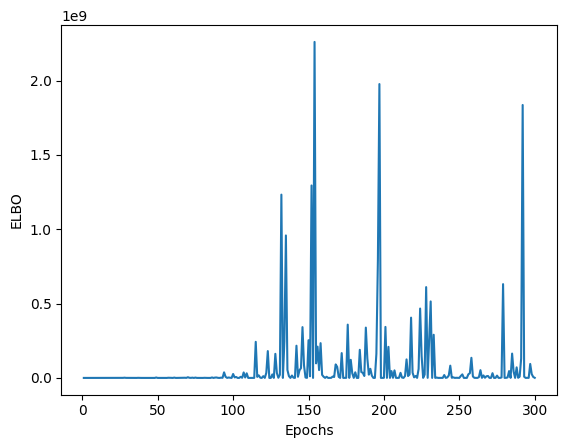

valid:
(381,)
   accuracy        f1       auc  predictive_entropy  mutual_information
0  0.952756  0.963115  0.939261           20.237165           20.237165
test:
(188,)
   accuracy       f1       auc  predictive_entropy  mutual_information
0  0.968085  0.97541  0.961885            10.39131            10.39131


In [17]:
model = BNN(hid_dim=48, n_hid_layers=3)
guide = AutoNormalizingFlow(model,transform_init)
predictive = variational_train(model,guide,loaders_dict)
preds = predictive(X_train_mc)


  0%|          | 0/25 [00:00<?, ?it/s]

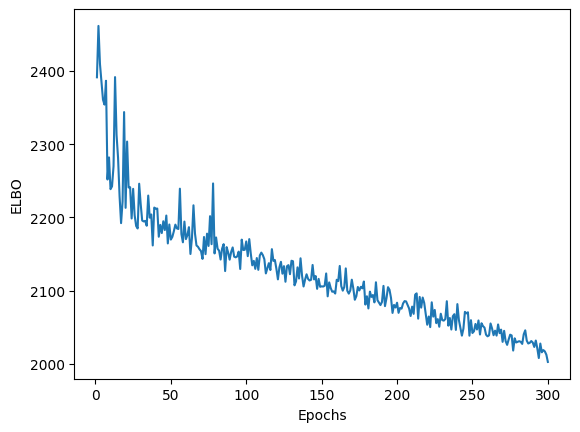

valid:
(381,)
   accuracy        f1       auc  predictive_entropy  mutual_information
0  0.976378  0.981211  0.970295           14.416606           14.225639
test:
(188,)
   accuracy        f1       auc  predictive_entropy  mutual_information
0  0.973404  0.979592  0.966017            7.575202            7.329043


In [18]:
model = BNN()
guide = AutoDiagonalNormal(model)
predictive = variational_train(model,guide,loaders_dict)
preds = predictive(X_train_mc)

In [19]:
X_train_mc

tensor([[ 0.35582, -1.72665,  0.41303,  ...,  1.05652,  0.51844,  0.98925],
        [-0.37327,  0.50881, -0.39470,  ..., -0.89667, -0.63237, -0.11470],
        [ 1.40336, -0.15145,  1.34800,  ...,  1.46354,  1.02587, -0.03370],
        ...,
        [ 0.02899, -0.56411, -0.08291,  ..., -1.24633, -0.67979, -1.26509],
        [-0.05761,  0.09615, -0.04957,  ...,  1.05652,  0.45995,  1.24414],
        [-0.56043,  0.30838, -0.61462,  ..., -0.61454, -0.30673, -0.83575]])

In [20]:
# # define model and data
# model = BNN()

# model = mcmc_train(model,X_train_mc,y_train_mc)
# preds = predictive(X_train_mc)


In [21]:
# pyro.clear_param_store()
# model = BNN()
# transform_init = partial(iterated,2,block_autoregressive,hidden_factors = [16,16])
# guide = AutoNormalizingFlow(model,transform_init)
# model = variational_train(model,guide,loaders_dict,epochs = 50)


In [22]:
ensemble_size = 3
ensemble = [MLP(hidden_dim=30, n_hidden_layers=2) for _ in range(ensemble_size)]
ensemble = [deterministic_train(net, loaders_dict) for net in ensemble]


  0%|          | 0/3000 [00:00<?, ?it/s]

valid:


TypeError: Singleton array array(1) cannot be considered a valid collection.

In [ ]:
## Implementação usando Ensemble de Modelos
## entropia preditiva muito menor , modelo mias certo da resposta
ensemble_preds = [net(X_test_mc).clone().detach() for net in ensemble]
ensemble_preds = np.clip(torch.stack(ensemble_preds, dim=0).detach().numpy(),0,1)
mean = np.mean(ensemble_preds, axis=0)
_preds = np.where(mean > 0.5, 1, 0)
pred_entropy = predictive_entropy(ensemble_preds.T)
mutual_info = mutual_information(ensemble_preds.T)
acc = accuracy_score(y_test_mc,_preds)
f1 = f1_score(y_test_mc,_preds)
auc = roc_auc_score(y_test_mc,mean)
pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])


In [ ]:
## Implementação usando Dropout

net_dropout = MLP(hidden_dim=30, n_hidden_layers=2, use_dropout=True,p_dropout=0.5)
net_dropout = deterministic_train(net_dropout, loaders_dict)

In [ ]:
n_dropout_samples = 100

# compute predictions, resampling dropout mask for each forward pass
dropout_preds = np.array([net_dropout(X_test_mc).clone().detach().numpy() for _ in range(n_dropout_samples)])
# dropout_preds = np.clip(np.array(dropout_preds),0,1)
mean = np.mean(dropout_preds, axis=0)
_preds = np.where(mean > 0.5, 1, 0)
pred_entropy = predictive_entropy(dropout_preds.T)
mutual_info = mutual_information(dropout_preds.T)
acc = accuracy_score(y_test_mc,_preds)
f1 = f1_score(y_test_mc,_preds)
auc = roc_auc_score(y_test_mc,mean)
pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,"mutual_information":mutual_info},index = [0])